In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [33]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = r"C:\Users\91905\potato disease\training\PlantVillage(copy)"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [34]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
     "PlantVillage", 
      shuffle=True, 
      image_size = (IMAGE_SIZE,IMAGE_SIZE), 
      batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [36]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [37]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [38]:
len(dataset)

68

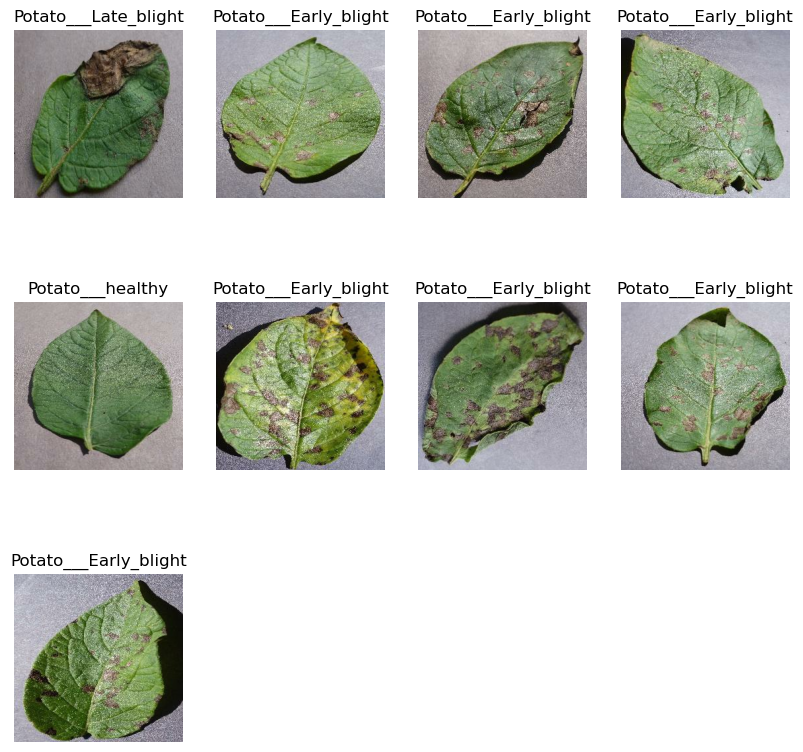

In [39]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [40]:
len(dataset)

68

In [41]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (829920516.py, line 1)

In [42]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [43]:
train_ds = dataset.take(54)
len(train_ds)

54

In [44]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [45]:
val_size= 0.1
len(dataset)*val_size 

6.800000000000001

In [46]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [47]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [48]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [49]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [50]:
len(train_ds)


54

In [51]:
len(val_ds)

6

In [52]:
len(test_ds)

8

In [53]:
train_ds =  train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =  train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =  train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [55]:
data_augmentation = tf.keras.Sequential([
   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [56]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [57]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [59]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
54/54 [==============================] - 151s 3s/step - loss: 0.9161 - accuracy: 0.4699 - val_loss: 0.8668 - val_accuracy: 0.5116
Epoch 2/10
54/54 [==============================] - 142s 3s/step - loss: 0.7112 - accuracy: 0.6869 - val_loss: 0.5517 - val_accuracy: 0.7488
Epoch 3/10
54/54 [==============================] - 142s 3s/step - loss: 0.4527 - accuracy: 0.8009 - val_loss: 0.4374 - val_accuracy: 0.8154
Epoch 4/10
54/54 [==============================] - 141s 3s/step - loss: 0.3808 - accuracy: 0.8513 - val_loss: 0.5335 - val_accuracy: 0.8223
Epoch 5/10
54/54 [==============================] - 142s 3s/step - loss: 0.3180 - accuracy: 0.8686 - val_loss: 0.3844 - val_accuracy: 0.8391
Epoch 6/10
54/54 [==============================] - 142s 3s/step - loss: 0.2325 - accuracy: 0.9120 - val_loss: 0.2281 - val_accuracy: 0.9196
Epoch 7/10
54/54 [==============================] - 141s 3s/step - loss: 0.2186 - accuracy: 0.9115 - val_loss: 0.1316 - val_accuracy: 0.9410
Epoch 8/10
54

In [61]:
scores = model.evaluate(test_ds)

54/54 [==============================] - 28s 510ms/step - loss: 0.1547 - accuracy: 0.9404


In [62]:
scores

[0.15466448664665222, 0.9403935074806213]

In [63]:
history


In [65]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [67]:
history.history['accuracy']

[0.46990740299224854,
 0.6869212985038757,
 0.8009259104728699,
 0.8512731194496155,
 0.8686342835426331,
 0.9120370149612427,
 0.9114583134651184,
 0.9207175970077515,
 0.8964120149612427,
 0.9212962985038757]

first image to predict
first image's actual label:  Potato___Early_blight
1/1 [==============================] - 1s 609ms/step
predicted label: Potato___Early_blight


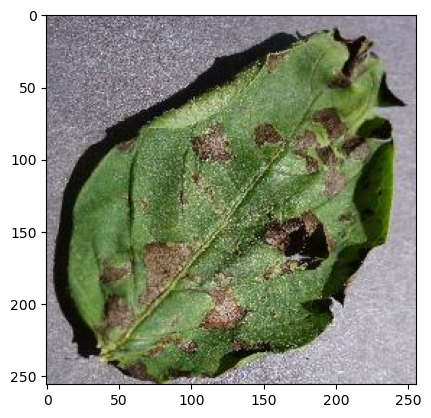

In [87]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[10].numpy().astype('uint8')
    first_label = labels_batch[10].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[10])])
    